<a href="https://colab.research.google.com/github/Tieck-IT/GAN_paper_study/blob/main/GAN/torch_GAN%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

using device cuda


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw

Epoch [0/200], Step [300/600],d_loss: 0.26636469, g_loss: 2.97540283, D(x): 0.88, D(G(z)): 0.12
Epoch [0/200], Step [600/600],d_loss: 0.04657982, g_loss: 5.06663275, D(x): 0.98, D(G(z)): 0.02
Epoch [1/200], Step [300/600],d_loss: 0.05762162, g_loss: 5.17659950, D(x): 0.97, D(G(z)): 0.02
Epoch [1/200], Step [600/600],d_loss: 0.13241237, g_loss: 4.55174351, D(x): 0.95, D(G(z)): 0.04
Epoch [2/200], Step [300/600],d_loss: 0.12403736, g_loss: 3.55990958, D(x): 0.99, D(G(z)): 0.10
Epoch [2/200], Step [600/600],d_loss: 0.52680045, g_loss: 2.88099217, D(x): 0.81, D(G(z)): 0.16
Epoch [3/200], Step [300/600],d_loss: 0.09373654, g_loss: 4.25919819, D(x): 0.98, D(G(z)): 0.06
Epoch [3/200], Step [600/600],d_loss: 0.25857931, g_loss: 3.07348204, D(x): 0.91, D(G(z)): 0.12
Epoch [4/200], Step [300/600],d_loss: 0.52953535, g_loss: 3.38297987, D(x): 0.78, D(G(z)): 0.05
Epoch [4/200], Step [600/600],d_loss: 0.06741381, g_l

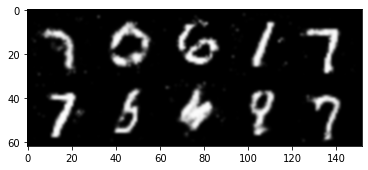

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt

def grid_image(tensor_images, size=10, nrow=5):
  tensor_images = ((tensor_images + 1) / 2 ).clamp(0, 1)
  return torchvision.utils.make_grid(tensor_images[:size], nrow=nrow)

def show_image(tensor_images, size=10, nrow=5):
  to_pil = transforms.ToPILImage()
  grid_img = grid_image(tensor_images)
  plt.imshow(to_pil(grid_img), interpolation="bicubic")

class Discriminator(nn.Module):
  def __init__(self, image_size, hidden_size):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Linear(image_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid()
    )
  def forward(self, x):
    return self.main(x)

class Generator(nn.Module):
  def __init__(self, latent_size, hidden_size, image_size):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.Linear(latent_size, hidden_size),
        nn.ReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(0.2),
        nn.Linear(hidden_size, image_size),
        nn.Tanh()
    )
  def forward(self, x):
    return self.main(x)

def binary_cross_entropy(out, target): # V(G,D)
  return - torch.mean(target * torch.log(out + 1e-10) + (1-target) * torch.log(1-out+1e-10))

def main():
  
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(f"using device {device}")
  # Hyper-parameters

  latent_size = 64
  hidden_size = 256
  image_size = 784

  num_epochs = 200
  batch_size = 100
  sample_dir = 'samples'

  if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])                              
  ])

  mnist = torchvision.datasets.MNIST(root='../../data/',
                                    train=True,
                                    transform=transform,
                                    download=True)

  data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                            batch_size=batch_size,
                                            shuffle=True)

  D = Discriminator(image_size, hidden_size).to(device)
  G = Generator(latent_size, hidden_size, image_size).to(device)

  criterion = nn.BCELoss()
  d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
  g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

  total_step = len(data_loader)
  def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
  
  def rand_z():
    return torch.randn(batch_size, latent_size).to(device)

  for epoch in range(num_epochs):
    fake_images = None
    for i, (images, _) in enumerate(data_loader):
      images = images.view(batch_size, -1).to(device)

      real_label = torch.ones(batch_size, 1).to(device)
      fake_label = torch.zeros(batch_size, 1).to(device)

      # ---- D ----
      z = rand_z()

      # real
      real_outputs = D(images)
      d_loss_real = binary_cross_entropy(real_outputs, real_label)
      real_score = real_outputs

      # fake
      fake_images = G(z)
      fake_outputs = D(fake_images)
      d_loss_fake = binary_cross_entropy(fake_outputs, fake_label)
      fake_score = fake_outputs
      
      # loss
      d_loss = d_loss_real + d_loss_fake
      
      # backprop
      reset_grad()
      d_loss.backward()
      d_optimizer.step()

      # ---- G ----
      z = rand_z()
      fake_images = G(z)
      outputs = D(fake_images)
      g_loss = binary_cross_entropy(outputs, real_label)
      
      reset_grad()
      g_loss.backward()
      g_optimizer.step()

      if (i + 1) % 300 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}],' + 
        f'd_loss: {d_loss:.8f}, g_loss: {g_loss:.8f}, ' + 
        f'D(x): {real_score.mean():.2f}, D(G(z)): {fake_score.mean():.2f}')
    if (epoch + 1) % 10 == 0:
      save_image(grid_image(fake_images.view(batch_size, 1, 28, 28)),
                  os.path.join(sample_dir, f'real_images_{epoch+1:03d}.png'))
    
    if (epoch + 1) % 50 == 0:
      show_image(fake_images.view(batch_size, 1, 28, 28))
    
      

main()